<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Report
</div>


In [95]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/ML/BIO/HW4")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [96]:
# Download train and val dataset
!wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
!wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

## A. Data Loading and Preprocessing

In [107]:
# Define a transform function
def resnet_transform(is_train=True):
    if is_train:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [108]:
from torch.utils.data import Dataset
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [109]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Load Dataset
x_train = np.transpose(np.load('report_train.npy'), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy'), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


In [110]:
from torchvision import transforms
batch_size = 32

# Create datasets
train_dataset = CustomTensorDataset(tensors=(x_train, y_train), transform=resnet_transform(is_train=True))
val_dataset = CustomTensorDataset(tensors=(x_val, y_val), transform=resnet_transform(is_train=False))

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Number of samples in train and validation are 2550 and 600.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


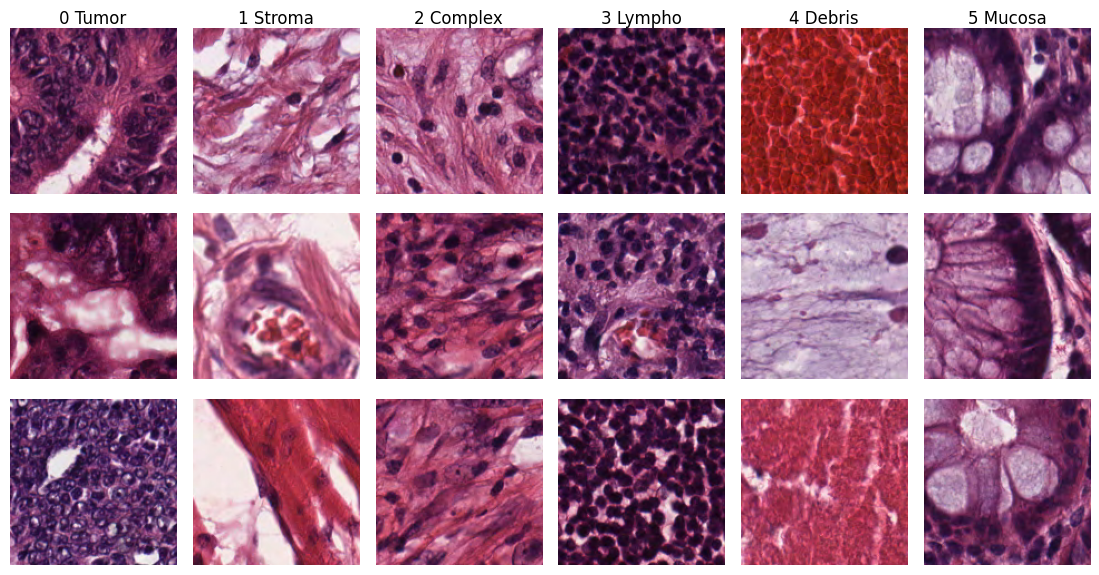

In [111]:
import matplotlib.pyplot as plt
import random

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 3

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 6))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_train == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)

    for i in range(samples_per_class):
        ax = axes[i, class_idx]
        img = x_train[random_indices[i]].numpy().transpose((1, 2, 0))
        img = img / img.max()
        ax.imshow(img)
        ax.axis('off')

        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

## B. Defining Neural Networks

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

In [113]:
from torchvision import models
import torch.nn as nn

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Number of features in the last layer (fc) of ResNet-18
num_ftrs = model.fc.in_features

# Replace the final fully connected layer with a new one with 6 outputs (for 6 classes)
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout
    nn.Linear(num_ftrs, 6)
)

## C. Training the Neural Network

In [148]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=2e-4)
def train_model(model, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(torch.max(outputs, 1)[1] == labels)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(torch.max(outputs, 1)[1] == labels)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%')
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [149]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, num_epochs=10)
torch.save(model.state_dict(), './Model_weights')

Epoch 1/10 - Train Loss: 0.5820, Train Acc: 78.90%, Val Loss: 1.2654, Val Acc: 72.67%
Epoch 2/10 - Train Loss: 0.5667, Train Acc: 80.12%, Val Loss: 0.3760, Val Acc: 85.67%
Epoch 3/10 - Train Loss: 0.5369, Train Acc: 80.75%, Val Loss: 0.4098, Val Acc: 83.67%
Epoch 4/10 - Train Loss: 0.4936, Train Acc: 82.51%, Val Loss: 0.4866, Val Acc: 84.17%
Epoch 5/10 - Train Loss: 0.5412, Train Acc: 80.59%, Val Loss: 0.3984, Val Acc: 86.33%
Epoch 6/10 - Train Loss: 0.5145, Train Acc: 81.25%, Val Loss: 0.3434, Val Acc: 88.00%
Epoch 7/10 - Train Loss: 0.5354, Train Acc: 80.24%, Val Loss: 0.4758, Val Acc: 82.50%
Epoch 8/10 - Train Loss: 0.4929, Train Acc: 82.90%, Val Loss: 0.7534, Val Acc: 72.17%
Epoch 9/10 - Train Loss: 0.4970, Train Acc: 82.55%, Val Loss: 0.4192, Val Acc: 84.17%
Epoch 10/10 - Train Loss: 0.5162, Train Acc: 80.63%, Val Loss: 0.4050, Val Acc: 85.00%


## D. Evaluating Your Trained Model

### Process Test Dataset

In [150]:
from torchvision import transforms

# Define the test transformations
test_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Needed as the input tensor needs to be converted to PIL Image for following transformations
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [151]:
from torch.utils.data import Dataset

class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [152]:
# Download test dataset,
!wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [153]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

batch_size = 32

from torch.utils.data import DataLoader

# Assuming x_test and y_test are your test data tensors
test_dataset = CustomTensorDataset(tensors=(x_test, y_test), transform=test_transforms)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [154]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout
    nn.Linear(num_ftrs, 6)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [155]:
model.load_state_dict(torch.load('./Model_weights'))

<All keys matched successfully>

Test Loss: 0.0124, Test Accuracy: 86.33%


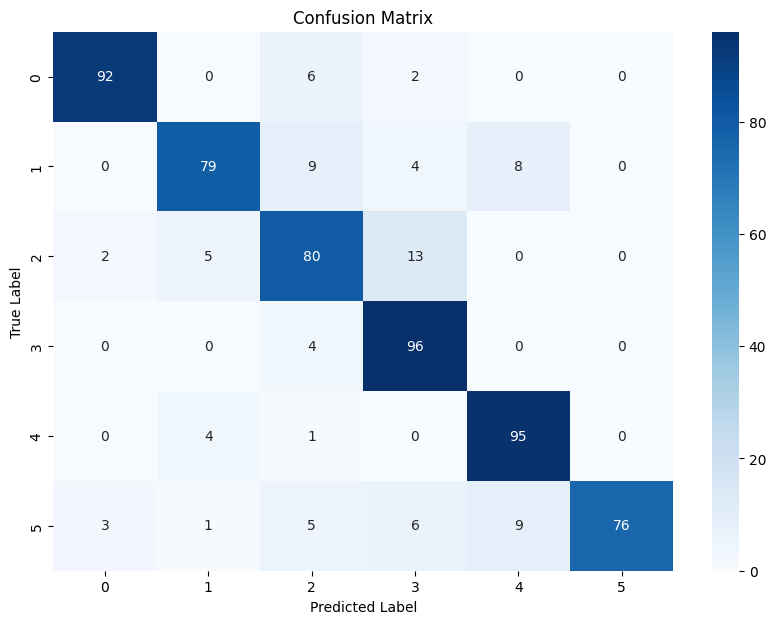

In [160]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Define the loss function, same as used during training
criterion = nn.CrossEntropyLoss()

test_loss = 0
correct = 0

# Prepare to collect true and predicted labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation to save memory and computations
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()

        # Get predictions
        preds = outputs.argmax(dim=1)

        # Collect the predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate the number of correct predictions
        correct += preds.eq(labels.view_as(preds)).sum().item()

# Calculate test loss and accuracy
test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Balance data

In [157]:
from collections import Counter

def get_class_distribution(loader):
    count = Counter()
    for _, labels in loader:
        count.update(labels.tolist())
    return count

train_count = get_class_distribution(train_loader)
val_count = get_class_distribution(val_loader)
test_count = get_class_distribution(test_loader)

In [158]:
def calculate_percentages(count_dict):
    total = sum(count_dict.values())
    percentages = {k: (v / total) * 100 for k, v in count_dict.items()}
    return percentages

train_percentages = calculate_percentages(train_count)
val_percentages = calculate_percentages(val_count)
test_percentages = calculate_percentages(test_count)

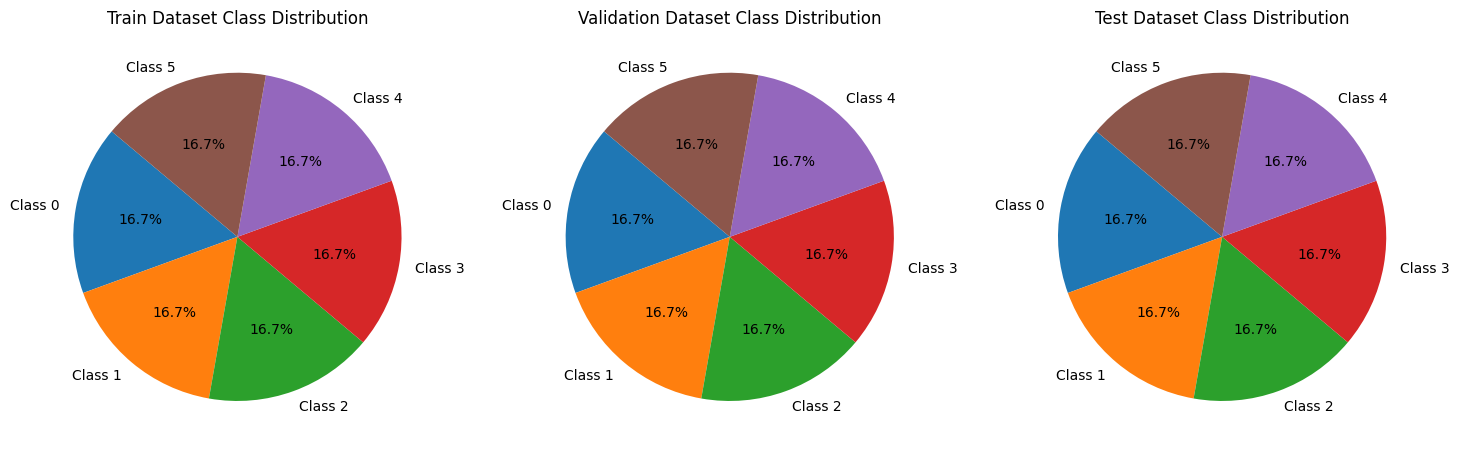

In [159]:
import matplotlib.pyplot as plt

# Assuming the classes are named from 0 to 5
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train Dataset Pie Chart
axes[0].pie(train_percentages.values(), labels=class_names, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Train Dataset Class Distribution')

# Validation Dataset Pie Chart
axes[1].pie(val_percentages.values(), labels=class_names, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Validation Dataset Class Distribution')

# Test Dataset Pie Chart
axes[2].pie(test_percentages.values(), labels=class_names, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Test Dataset Class Distribution')

plt.show()